In [1]:
"""
Local setup - Mac Mini M4 Apple Silicon - check requirements.txt file.
Run this script to download spacy model before you run the notebook.
"""

"""

import os
os.environ["PYTHONWARNINGS"] = "ignore"


!python3 -m spacy download en_core_web_sm

"""




'\n\nimport os\nos.environ["PYTHONWARNINGS"] = "ignore"\n\n\n!python3 -m spacy download en_core_web_sm\n\n'

In [20]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"


import warnings
import urllib3.exceptions
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", urllib3.exceptions.NotOpenSSLWarning)

import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import re
import html
import spacy

from collections import Counter

from tqdm import tqdm
from tqdm.keras import TqdmCallback

tqdm.pandas()

from dataclasses import dataclass

import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples
from sklearn.metrics import classification_report, confusion_matrix

from typing import Any


In [3]:
@dataclass
class Config:
    DATA_PATH: str = "twitter_training.csv"
    RANDOM_SEED: int = 28
    SPACY_MODEL: str = "en_core_web_sm"
    TEXT_VECTOR_MAX_TOKENS:int = 5000
    TEXT_VECTOR_OUTPUT_MODE: str = "int"
    TEXT_VECTOR_OUTPUT_SEQUENCE_LENGTH:int =300
    TEXT_VECTOR_EMBEDDING_DIMENSION:int = 64 # Recommended value for tweets and short texts
    VECTORIZER: Any = None
    TOTAL_EPOCHS: int = 10
    BATCH_SIZE: int = 254
    EARLY_STOPPING_PATIENCE: int = 5
    LSTM_UNITS: int = 64 # Keeping the embedding dimension size in mind
    HIDDEN_UNITS: int = 32
    DROPOUT_RATE: float = 0.2



GlobalConfig = Config()



def set_global_seed(seed_value: int) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)    

set_global_seed(GlobalConfig.RANDOM_SEED)

# Part 1 - Data Processing

## 1.1 Loading the dataset & 1.2 Data Cleaning

In [4]:

def load_and_setup_data() -> pd.DataFrame:
    df = pd.read_csv(GlobalConfig.DATA_PATH)    
    # First column appers to be some sort file or sequence number and the second appears to be the source
    # Those two columns do not have any impact on sentiment analysis
    # Take the last two columns
    df = df.iloc[:, -2:]
    # Swap columns 1 and 2
    df = df[[df.columns[1], df.columns[0]]]
    # Setup column names
    df.columns = ["tweet", "sentiment"]
    # Remove empty rows
    df = df.dropna()
    # Remove where sentiment is "Irrelevant"
    df = df[df["sentiment"] != "Irrelevant"]
    # Remove diuplicate rows
    df = df.drop_duplicates()
    # Look for tweets where the same tweet is classified as a different sentiment
    # Take the first occurence - this will get us clean data and will not mislead the classifier later during training
    df = df.drop_duplicates(subset=["tweet"], keep="first")
    return df

df = load_and_setup_data()


# Just keep the essentials, remove named entities, parsing and sentence segmentation for speed
nlp = spacy.load(GlobalConfig.SPACY_MODEL, disable=["ner", "parser", "senter"])


def clean_and_pre_process(texts: list[str]) -> list[str]:        
    url_pattern = re.compile(r"http\S+|www\S+|https\S+")
    twitter_handle_pattern = re.compile(r"\@\w+|\#")
    non_alpha_pattern = re.compile(r"[^a-zA-Z\s]")

    cleaned_texts: list[str] = []
    for text in texts:
        text = url_pattern.sub("", text)
        text = twitter_handle_pattern.sub("", text)
        text = non_alpha_pattern.sub("", text)
        cleaned_texts.append(text.strip().lower())

    docs = nlp.pipe(cleaned_texts, batch_size=2000, n_process=-1)

    final_texts: list[str] = []
    for doc in tqdm(docs, total=len(cleaned_texts)):
        # This is a key line - we are lemmatizing, removing stop words, punctuation and single character tokens
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.lemma_) > 1]
        final_texts.append(" ".join(tokens))

    return final_texts
    
    
df["sanitized_tweet"] = clean_and_pre_process(df["tweet"].tolist())
df.head()

100%|██████████| 57296/57296 [00:17<00:00, 3188.16it/s]


,tweet,sentiment,sanitized_tweet
0,I am coming to the borders and I will kill you...,Positive,come border kill
1,im getting on borderlands and i will kill you ...,Positive,get borderland kill
2,im coming on borderlands and i will murder you...,Positive,come borderland murder
3,im getting on borderlands 2 and i will murder ...,Positive,get borderland murder
4,im getting into borderlands and i can murder y...,Positive,get borderland murder


## 1.3 Feature Engineering

In [5]:
def create_tokenized_words(df: pd.DataFrame) -> tuple[pd.DataFrame, Any]:
    texts = df["sanitized_tweet"].values
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=GlobalConfig.TEXT_VECTOR_MAX_TOKENS, 
        output_mode=GlobalConfig.TEXT_VECTOR_OUTPUT_MODE, 
        output_sequence_length=GlobalConfig.TEXT_VECTOR_OUTPUT_SEQUENCE_LENGTH
    )   
    vectorizer.adapt(texts)
    # Convert text to integer sequences - which will then be fed into the embedding layer
    tfidf_vectors = vectorizer(texts)
    # add the tokenized words as a new column
    df["sanitized_tweet_vector"] = list(tfidf_vectors.numpy())
    return (df, vectorizer)

df, GlobalConfig.VECTORIZER = create_tokenized_words(df)
df.head()

2025-12-26 13:44:43.213140: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-26 13:44:43.214340: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-26 13:44:43.214357: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-26 13:44:43.214763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-26 13:44:43.214780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-12-26 13:44:43.520561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


,tweet,sentiment,sanitized_tweet,sanitized_tweet_vector
0,I am coming to the borders and I will kill you...,Positive,come border kill,"[30, 1496, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,im getting on borderlands and i will kill you ...,Positive,get borderland kill,"[7, 50, 82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,im coming on borderlands and i will murder you...,Positive,come borderland murder,"[30, 50, 1111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,im getting on borderlands 2 and i will murder ...,Positive,get borderland murder,"[7, 50, 1111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,im getting into borderlands and i can murder y...,Positive,get borderland murder,"[7, 50, 1111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# Part 2 - Exploratory Data Analysis (EDA)

## 2.1 Basic Statistics

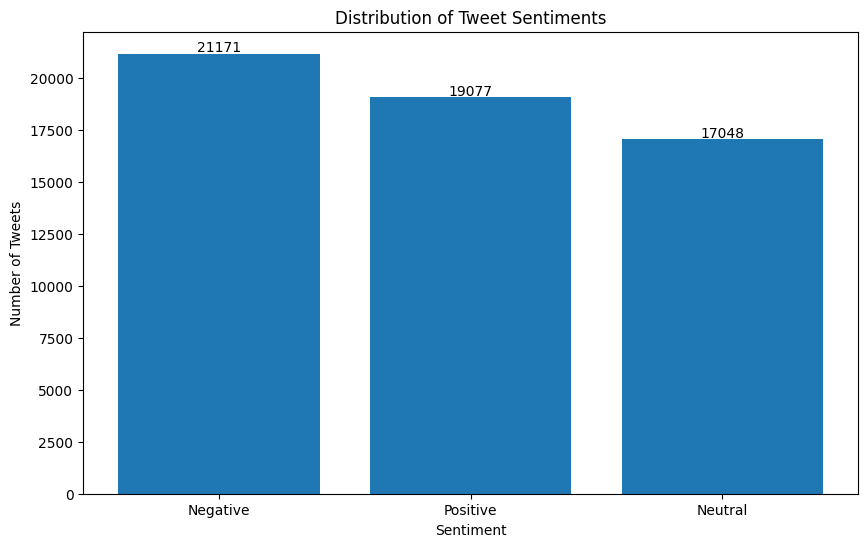

In [6]:
# Explore the distribution of tweet sentiments (e.g., how many positive, negative, and neutral tweets are there?).
# Plot a simple bar chart
sentiment_counts = df["sentiment"].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values.tolist())
# Add total counts on top of each bar
for i, count in enumerate(sentiment_counts.values):
    plt.text(i, count + 100, str(count), ha="center")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweet Sentiments")
plt.show()


## 2.2 Visualizations

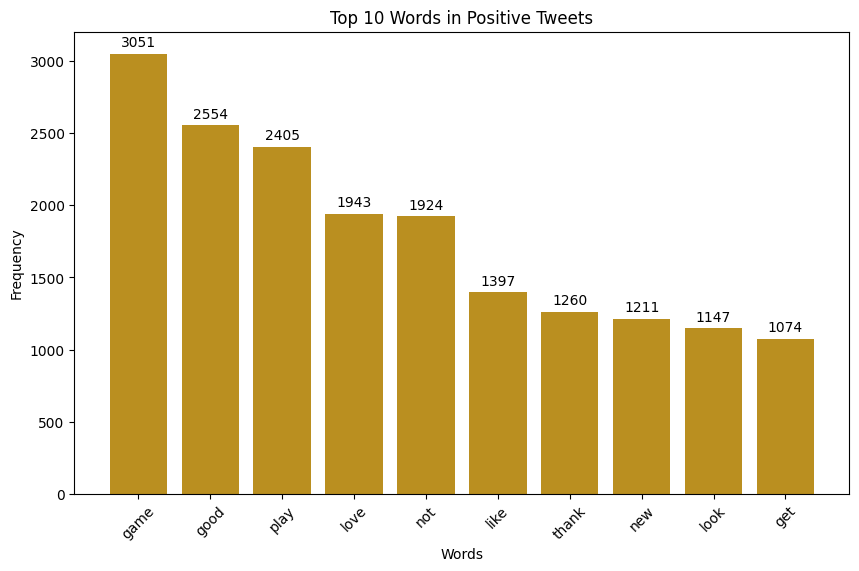

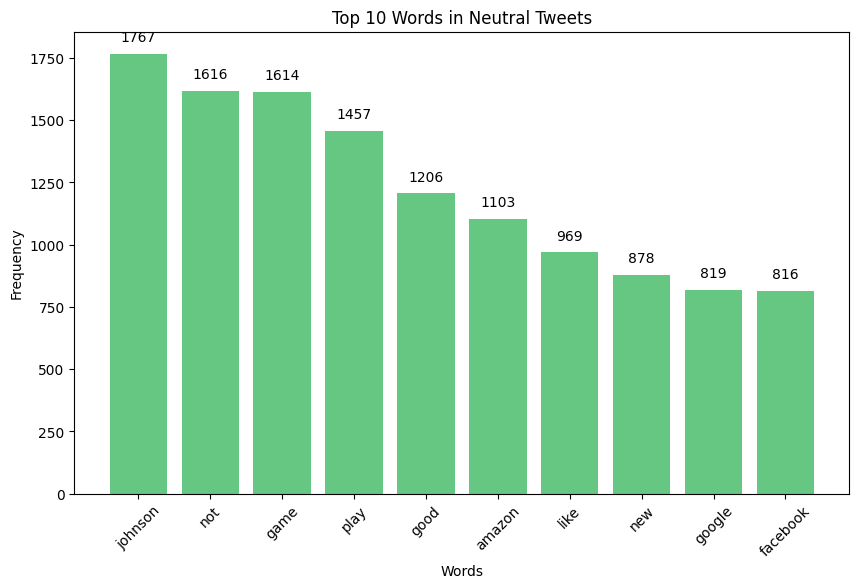

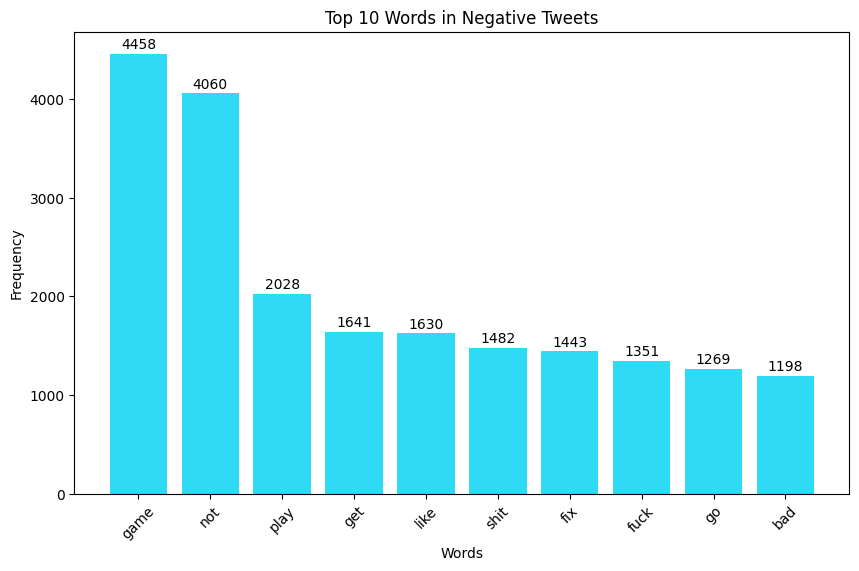

In [7]:
# Frequency of top words in Positive, Negative and Neutral tweets

sentiment_categories = df["sentiment"].unique()

def show_top_words(df: pd.DataFrame, sentiment_categories: list[str]) -> None:
    top_n = 10
    for sentiment in sentiment_categories:
        subset = df[df["sentiment"] == sentiment]
        all_words = " ".join(subset["sanitized_tweet"]).split()
        word_counts = Counter(all_words)
        most_common_words = word_counts.most_common(top_n)    
        words, counts = zip(*most_common_words)    
        plt.figure(figsize=(10, 6))
        plt.bar(words, counts, color = np.random.rand(3,))
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.title(f"Top {top_n} Words in {sentiment} Tweets")
        plt.xticks(rotation=45)
        for i, count in enumerate(counts):
            plt.text(i, count + 50, str(count), ha="center")
        plt.show()

show_top_words(df, sentiment_categories.tolist())

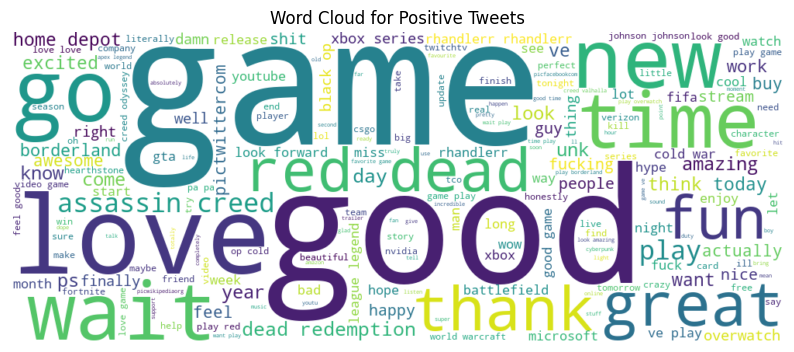

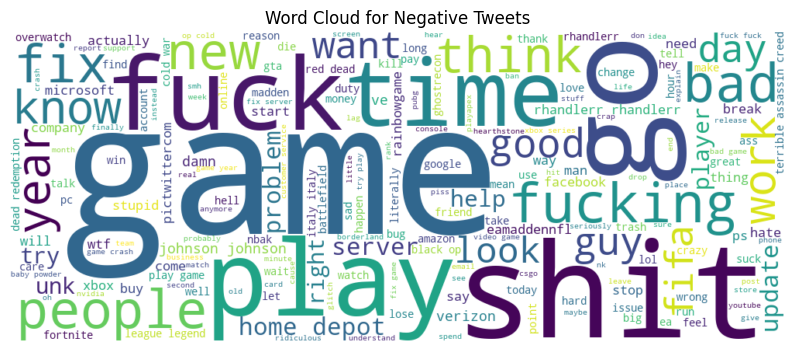

In [8]:

def create_wordcloud() -> None:
    # Wordcloud for positive and negative tweets
    for sentiment in ["Positive", "Negative"]:
        subset = df[df["sentiment"] == sentiment]
        all_words = " ".join(subset["sanitized_tweet"])
        wordcloud = WordCloud(width=1000, height=400, background_color="white").generate(all_words)
        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {sentiment} Tweets")
        plt.show()
        
create_wordcloud()

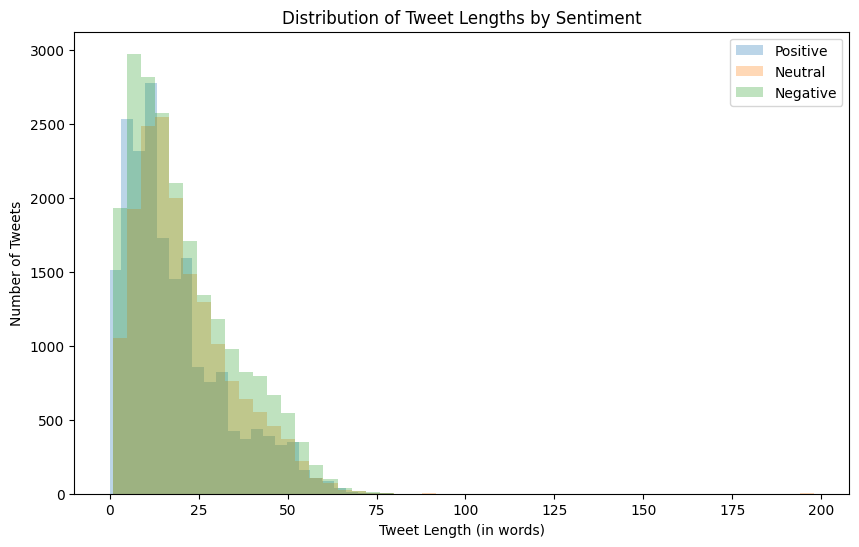

In [9]:

def show_relationship_between_tweet_length_and_sentiment() -> None:
    # Relationthip between tweet length and sentiment
    df["tweet_length"] = df["tweet"].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 6))
    for sentiment in sentiment_categories:
        subset = df[df["sentiment"] == sentiment]
        plt.hist(subset["tweet_length"], bins=50, alpha=0.3, label=sentiment)
    plt.xlabel("Tweet Length (in words)")
    plt.ylabel("Number of Tweets")
    plt.title("Distribution of Tweet Lengths by Sentiment")
    plt.legend()
    plt.show() 

show_relationship_between_tweet_length_and_sentiment()

## 2.3 Insights

* There is no distinct visble relationship between the length of a tweet and it's sentiment. Negative tweets are slightly longer.
* The words "game" & "play" are in top 10 for Positive, Negative and Neutral tweets.
* Tweets cannot be classified based on just 1 or 2 words, we need to know the "Context" under which they are used.

# Part 3 - Building the RNN Model

## 3.1 Model Architecture

In [10]:
def build_rnn_model() -> keras.Model:
    model = keras.Sequential()
    model.add(keras.Input(shape=(GlobalConfig.TEXT_VECTOR_OUTPUT_SEQUENCE_LENGTH,)))
    
    model.add(
        keras.layers.Embedding(
            input_dim=GlobalConfig.TEXT_VECTOR_MAX_TOKENS, 
            output_dim=GlobalConfig.TEXT_VECTOR_EMBEDDING_DIMENSION
        )
    )    
    
    model.add(keras.layers.Bidirectional(
        keras.layers.LSTM(GlobalConfig.LSTM_UNITS, dropout=GlobalConfig.DROPOUT_RATE)
    ))

    model.add(keras.layers.Dense(GlobalConfig.HIDDEN_UNITS, activation="relu"))
    model.add(keras.layers.Dense(3, activation="softmax"))
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model = build_rnn_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           320000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 390275 (1.49 MB)
Trainable params: 390275 (1.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 3.2 Model Implementation

In [11]:
def prepare_data_for_model(df: pd.DataFrame) -> pd.DataFrame:
    label_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
    df["sentiment_label"] = df["sentiment"].map(label_mapping)
    return df
    
df = prepare_data_for_model(df)

def get_features_and_targets(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    X = np.array(list(df["sanitized_tweet_vector"].values))
    y = df["sentiment_label"].to_numpy(dtype=np.int32)
    return X, y

X, y = get_features_and_targets(df)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=GlobalConfig.RANDOM_SEED, stratify=y)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=GlobalConfig.EARLY_STOPPING_PATIENCE, restore_best_weights=True)

history = model.fit(
    X_train, 
    y_train, 
    validation_split=0.2, 
    epochs=GlobalConfig.TOTAL_EPOCHS, 
    batch_size=GlobalConfig.BATCH_SIZE, 
    callbacks=[early_stopping, TqdmCallback(verbose=1)],
    verbose=0

)



100%|██████████| 10/10 [01:35<00:00,  9.55s/epoch, loss=0.285, accuracy=0.895, val_loss=0.562, val_accuracy=0.817]


## 3.3 Evaluation

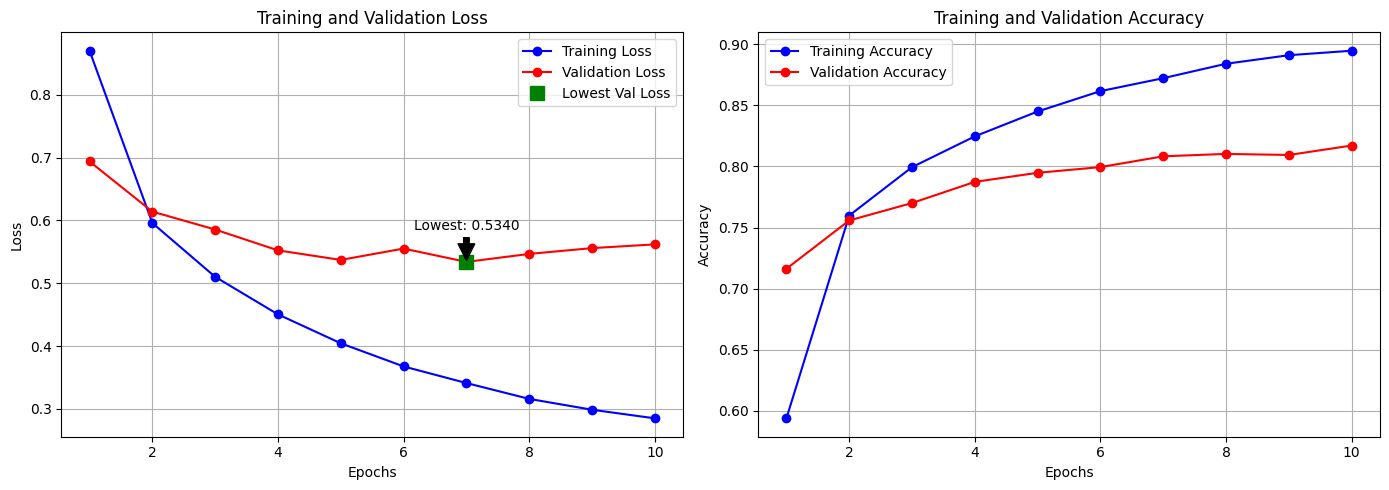

In [12]:
def plot_training_history(history):
    metrics = history.history
    loss = metrics["loss"]
    val_loss = metrics["val_loss"]
    accuracy = metrics["accuracy"]
    val_accuracy = metrics["val_accuracy"]
    epochs = range(1, len(loss) + 1)

    min_val_loss = min(val_loss)
    min_val_loss_epoch = val_loss.index(min_val_loss) + 1

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, "bo-", label="Training Loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation Loss")

    
    plt.plot(min_val_loss_epoch, min_val_loss, 'gs', markersize=10, label='Lowest Val Loss') # Green Square
    plt.annotate(
        f"Lowest: {min_val_loss:.4f}",
        xy=(min_val_loss_epoch, min_val_loss),
        xytext=(min_val_loss_epoch, min_val_loss + 0.05), # Offset text slightly up
        arrowprops=dict(facecolor='black', shrink=0.05),
        horizontalalignment='center'
    )

    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, "bo-", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "ro-", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_training_history(history)

In [13]:

model_unrestricted = build_rnn_model()


print(f"Starting unrestricted training for {GlobalConfig.TOTAL_EPOCHS} epochs ...")
history_unrestricted = model_unrestricted.fit(
    X_train, 
    y_train, 
    validation_split=0.2, 
    epochs=GlobalConfig.TOTAL_EPOCHS, 
    batch_size=GlobalConfig.BATCH_SIZE, 
    callbacks=[TqdmCallback(verbose=1)],
    verbose=0
)

Starting unrestricted training for 10 epochs ...


100%|██████████| 10/10 [01:35<00:00,  9.60s/epoch, loss=0.277, accuracy=0.897, val_loss=0.537, val_accuracy=0.824]


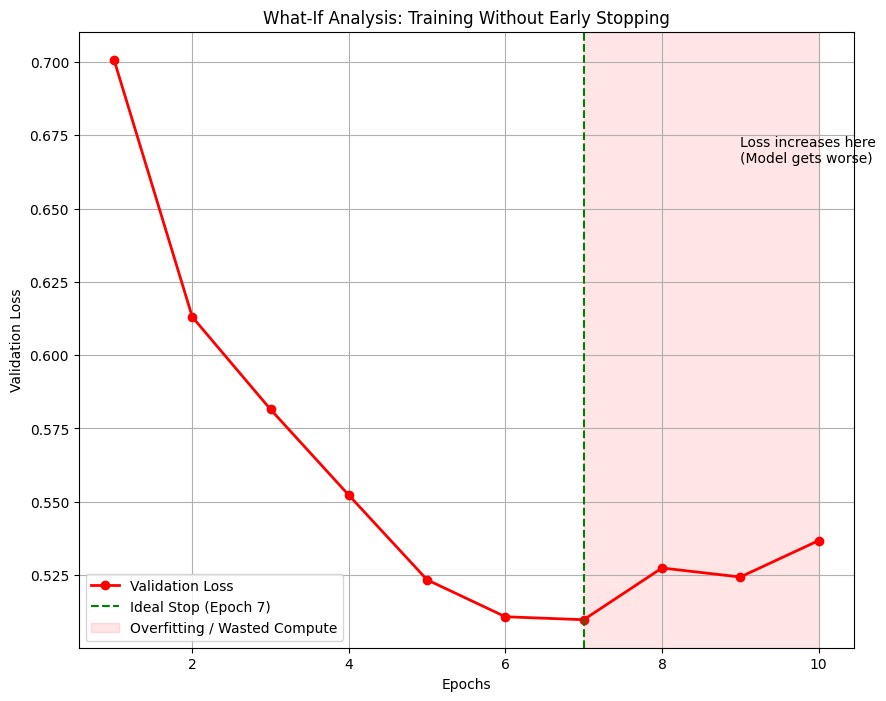

In [14]:
def plot_what_if_analysis_for_unrestricted_training(history):
    val_loss = history_unrestricted.history["val_loss"]
    epochs = range(1, len(val_loss) + 1)
    
    # Find the epoch where val_loss was minimum (Best Model)
    best_epoch_index = val_loss.index(min(val_loss))
    best_epoch = best_epoch_index + 1
    best_loss = val_loss[best_epoch_index]

    plt.figure(figsize=(10, 8))
    
    # Plot the curve
    plt.plot(epochs, val_loss, "r-o", label="Validation Loss", linewidth=2)
    
    # Vertical line at the Best Epoch
    plt.axvline(x=best_epoch, color="green", linestyle="--", label=f"Ideal Stop (Epoch {best_epoch})")
    
    # Shade the Overfitting Zone (What happened after)
    if best_epoch < len(epochs):
        plt.axvspan(best_epoch, len(epochs), color="red", alpha=0.1, label="Overfitting / Wasted Compute")
        
        # Add annotation arrow
        plt.annotate(
            "Loss increases here\n(Model gets worse)",
            xy=(len(epochs), val_loss[-1]),
            xytext=(best_epoch + 2, max(val_loss) * 0.95)           
        )

    plt.title("What-If Analysis: Training Without Early Stopping")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the plot
plot_what_if_analysis_for_unrestricted_training(history_unrestricted)

## 3.4 Model Improvement

In [15]:
def do_model_cross_validation() -> None:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=GlobalConfig.RANDOM_SEED)
    fold_no = 1
    accuracies = []

    for train_index, val_index in skf.split(X, y):        
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        model_cv = build_rnn_model()

        history_cv = model_cv.fit(
            X_train_fold,
            y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=GlobalConfig.TOTAL_EPOCHS,
            batch_size=GlobalConfig.BATCH_SIZE,
            callbacks=[early_stopping],
            verbose=0
        )

        scores = model_cv.evaluate(X_val_fold, y_val_fold, verbose=0)
        print(f"Fold {fold_no} - Validation Accuracy: {scores[1]*100:.2f}%")
        accuracies.append(scores[1] * 100)
        fold_no += 1

    print(f"Average Validation Accuracy across folds: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")

do_model_cross_validation()

Fold 1 - Validation Accuracy: 83.90%
Fold 2 - Validation Accuracy: 83.70%
Fold 3 - Validation Accuracy: 83.20%
Fold 4 - Validation Accuracy: 82.98%
Fold 5 - Validation Accuracy: 83.34%
Average Validation Accuracy across folds: 83.42% ± 0.33%


In [17]:
def do_model_grid_search(lstm_units_list: list[int], hidden_units_list: list[int], dropout_list: list[float]) -> None:
    best_accuracy = 0.0
    best_params = {}

    for lstm_unit in lstm_units_list:
        for hidden_unit in hidden_units_list:
            for dropout in dropout_list:
                print(f"Training model with {lstm_unit} lstm units, {hidden_unit} hidden units, and {dropout} dropout...")
                model_gs = keras.Sequential()
                model_gs.add(keras.Input(shape=(GlobalConfig.TEXT_VECTOR_OUTPUT_SEQUENCE_LENGTH,)))
                model_gs.add(
                    keras.layers.Embedding(
                        input_dim=GlobalConfig.TEXT_VECTOR_MAX_TOKENS, 
                        output_dim=GlobalConfig.TEXT_VECTOR_EMBEDDING_DIMENSION
                    )
                )    
                model_gs.add(keras.layers.Bidirectional(
                    keras.layers.LSTM(lstm_unit, dropout=dropout)
                ))
                model_gs.add(keras.layers.Dense(hidden_unit, activation="relu"))

                model_gs.add(keras.layers.Dense(3, activation="softmax"))
                model_gs.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

                history_gs = model_gs.fit(
                    X_train, 
                    y_train, 
                    validation_split=0.2, 
                    epochs=10, 
                    batch_size=GlobalConfig.BATCH_SIZE, 
                    callbacks=[early_stopping],
                    verbose=0
                )

                scores = model_gs.evaluate(X_test, y_test, verbose=0)
                accuracy = scores[1] * 100
                print(f"Test Accuracy: {accuracy:.2f}%")

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {"lstm unit": lstm_unit, "hidden unit": hidden_unit, "dropout": dropout}

    print(f"Best Test Accuracy: {best_accuracy:.2f}% with parameters: {best_params}")

do_model_grid_search(lstm_units_list=[64], hidden_units_list=[64] ,dropout_list=[0.0, 0.2, 0.3])

Training model with 64 lstm units, 64 hidden units, and 0.0 dropout...
Test Accuracy: 79.48%
Training model with 64 lstm units, 64 hidden units, and 0.2 dropout...
Test Accuracy: 81.02%
Training model with 64 lstm units, 64 hidden units, and 0.3 dropout...
Test Accuracy: 80.99%
Best Test Accuracy: 81.02% with parameters: {'lstm unit': 64, 'hidden unit': 64, 'dropout': 0.2}


# Benchmarking our Model with external data

Vectorizing 2000 tweets...
Running predictions...

 EXTERNAL DATASET BENCHMARK RESULTS
              precision    recall  f1-score   support

    Negative       0.54      0.33      0.41      1000
     Neutral       0.00      0.00      0.00         0
    Positive       0.52      0.72      0.60      1000

    accuracy                           0.53      2000
   macro avg       0.35      0.35      0.34      2000
weighted avg       0.53      0.53      0.51      2000



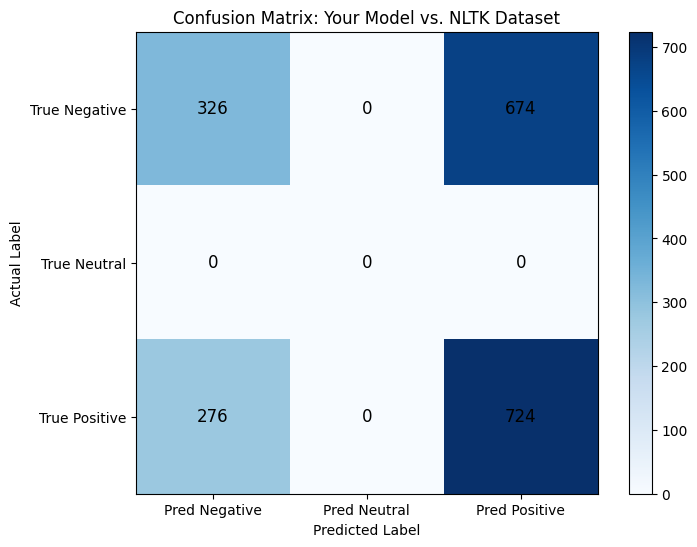

In [ ]:

def quick_cleanse(text: str) -> str:
    if not isinstance(text, str):
        return ""        
    text = html.unescape(text)        
    text = text.lower()        
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)        
    text = re.sub(r"@\w+", "", text)        
    text = re.sub(r"#", "", text)        
    text = re.sub(r"[^a-zA-Z\s]", "", text)        
    text = re.sub(r"\s+", " ", text).strip()    
    return text


def benchmark_model():
    
    print("Downloading NLTK Twitter dataset...")
    nltk.download("twitter_samples", quiet=True)
    raw_pos = [quick_cleanse(t) for t in twitter_samples.strings("positive_tweets.json")[:1000]]
    raw_neg = [quick_cleanse(t) for t in twitter_samples.strings("negative_tweets.json")[:1000]]        
    
    X_benchmark_text = raw_pos + raw_neg
    y_benchmark_true = np.array([2] * 1000 + [0] * 1000)

    
    print(f"Vectorizing {len(X_benchmark_text)} tweets...")
    X_benchmark_vectors = GlobalConfig.VECTORIZER(X_benchmark_text) # Reusing the saved vectorizer
    
    # 5. Predict with Your Model
    print("Running predictions...")
    y_pred_probs = model.predict(X_benchmark_vectors, verbose=0)
    y_pred_probs[:, 1] = -1 # No neutral class in benchmark dataset
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
    
    print("\n" + "="*40)
    print(" EXTERNAL DATASET BENCHMARK RESULTS")
    print("="*40)
    
    print(classification_report(
        y_benchmark_true, 
        y_pred_classes, 
        labels=[0, 1, 2],
        target_names=["Negative", "Neutral", "Positive"]
    ))

    
    cm = confusion_matrix(y_benchmark_true, y_pred_classes, labels=[0, 1, 2])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap="Blues")
    fig.colorbar(cax)

    
    ax.set_xticklabels([""] + ["Pred Negative", "Pred Neutral", "Pred Positive"])
    ax.set_yticklabels([""] + ["True Negative", "True Neutral", "True Positive"])
    
    
    ax.xaxis.set_ticks_position("bottom")
    
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), va="center", ha="center", color="black", fontsize=12)

    plt.title("Confusion Matrix: Your Model vs. NLTK Dataset")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()


benchmark_model()

## Obsevations
* Our accuracy with random tweets is as good as a coin toss
* This indicates that our vocabulary from twitter_training.csv is limited
* We could use a model like GloVe embeddings through transfer learning method